# CSI-777 Homework 4

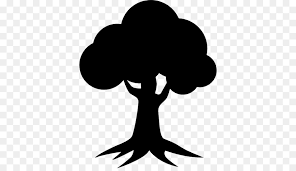

## Goal:

The purpose of this homework is to run the C4.5 algorithm over the iris dataset in order to classify the iris types.

## Background Research:

After looking for a good out of the box solution I managed to find the following repo [here](https://github.com/RaczeQ/scikit-learn-C4.5-tree-classifier/blob/master/) the methods will be taken from this to save me some coding time :)

## Import Dependencies / Data

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('iris.csv')
df.head()

,petallength,petalwidth,class
0,1.4,0.2,Iris-setosa
1,1.4,0.2,Iris-setosa
2,1.3,0.2,Iris-setosa
3,1.5,0.2,Iris-setosa
4,1.4,0.2,Iris-setosa


## Create methods for C4.5 Algorithm

In [3]:
import math
from xml.dom import minidom
from xml.etree import ElementTree as ET

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_array, check_is_fitted, check_X_y

import math
from xml.etree import ElementTree as ET


def prettify(elem, level=0):
    i = "\n" + level*"  "
    if len(elem):
        if not elem.text or not elem.text.strip():
            elem.text = i + "  "
        for e in elem:
            prettify(e, level+1)
        if not e.tail or not e.tail.strip():
            e.tail = i
    if level and (not elem.tail or not elem.tail.strip()):
        elem.tail = i
    return elem

def isnum(attr):
    for x in set(attr):
        if not x=="?":
            try:
                x=float(x)
                return isinstance(x,float)
            except ValueError:
                return False
    return True

def entropy(x):
    ent=0
    for k in set(x):
        p_i=float(x.count(k))/len(x)
        ent=ent-p_i* math.log(p_i,2)
    return ent

def gain_ratio(category,attr):
    s=0
    cat=[]
    att=[]
    for i in range(len(attr)):
        if not attr[i]=="?":
            cat.append(category[i])
            att.append(attr[i])
    for i in set(att):      
        p_i=float(att.count(i))/len(att)
        cat_i=[]
        for j in range(len(cat)):
            if att[j]==i:
                cat_i.append(cat[j])
        s=s+p_i*entropy(cat_i)
    gain=entropy(cat)-s
    ent_att=entropy(att)
    if ent_att==0:
        return 0
    else:
        return gain/ent_att

def gain(category,attr):
    cats=[]
    for i in range(len(attr)):
        if not attr[i]=="?":
            cats.append([float(attr[i]),category[i]])
    cats=sorted(cats, key=lambda x:x[0])
    
    cat=[cats[i][1] for i in range(len(cats))]
    att=[cats[i][0] for i in range(len(cats))]
    if len(set(att))==1:
        return 0
    else:
        gains=[]
        div_point=[]
        for i in range(1,len(cat)):
            if not att[i]==att[i-1]:
                gains.append(entropy(cat[:i])*float(i)/len(cat)+entropy(cat[i:])*(1-float(i)/len(cat)))
                div_point.append(i)
        gain=entropy(cat)-min(gains)
    
        p_1=float(div_point[gains.index(min(gains))])/len(cat)
        ent_attr= -p_1*math.log(p_1,2)-(1-p_1)*math.log((1-p_1),2)
        return gain/ent_attr

def division_point(category,attr):
    cats=[]
    for i in range(len(attr)):
        if not attr[i]=="?":
            cats.append([float(attr[i]),category[i]])
    cats=sorted(cats, key=lambda x:x[0])
    
    cat=[cats[i][1] for i in range(len(cats))]
    att=[cats[i][0] for i in range(len(cats))]
    gains=[]
    div_point=[]
    for i in range(1,len(cat)):
        if not att[i]==att[i-1]:
            gains.append(entropy(cat[:i])*float(i)/len(cat)+entropy(cat[i:])*(1-float(i)/len(cat)))
            div_point.append(i)
    return att[div_point[gains.index(min(gains))]]

def grow_tree(data,category,parent,attrs_names):
    if len(set(category))>1:
        
        division=[]
        for i in range(len(data)):
            if set(data[i])==set("?"):
                division.append(0)
            else:
                if (isnum(data[i])):
                    division.append(gain(category,data[i]))           
                else:
                    division.append(gain_ratio(category,data[i]))
        if max(division)==0:
            num_max=0
            for cat in set(category):
                num_cat=category.count(cat)
                if num_cat>num_max:
                    num_max=num_cat
                    most_cat=cat                
            parent.text=most_cat
        else:
            index_selected=division.index(max(division))
            name_selected=str(attrs_names[index_selected])
            if isnum(data[index_selected]):
                div_point=division_point(category,data[index_selected])
                r_son_data=[[] for i in range(len(data))]
                r_son_category=[]
                l_son_data=[[] for i in range(len(data))]
                l_son_category=[]
                for i in range(len(category)):
                    if not data[index_selected][i]=="?":
                        if float(data[index_selected][i])<float(div_point):
                            l_son_category.append(category[i])
                            for j in range(len(data)):
                                l_son_data[j].append(data[j][i])     
                        else:
                            r_son_category.append(category[i])
                            for j in range(len(data)):
                                r_son_data[j].append(data[j][i])  
                if len(l_son_category)>0 and len(r_son_category)>0:
                    p_l=float(len(l_son_category))/(len(data[index_selected])-data[index_selected].count("?"))
                    son=ET.SubElement(parent,name_selected,{'value':str(div_point),"flag":"l","p":str(round(p_l,3))})
                    grow_tree(l_son_data,l_son_category,son,attrs_names)
                    son=ET.SubElement(parent,name_selected,{'value':str(div_point),"flag":"r","p":str(round(1-p_l,3))})
                    grow_tree(r_son_data,r_son_category,son,attrs_names)
                else:
                    num_max=0
                    for cat in set(category):
                        num_cat=category.count(cat)
                        if num_cat>num_max:
                            num_max=num_cat
                            most_cat=cat                
                    parent.text=most_cat
            else:
                for k in set(data[index_selected]):
                    if not k=="?":
                        son_data=[[] for i in range(len(data))]
                        son_category=[]
                        for i in range(len(category)):
                            if data[index_selected][i]==k:
                                son_category.append(category[i])
                                for j in range(len(data)):
                                    son_data[j].append(data[j][i])
                        son=ET.SubElement(parent,name_selected,{'value':k,"flag":"m",'p':str(round(float(len(son_category))/(len(data[index_selected])-data[index_selected].count("?")),3))}) 
                        grow_tree(son_data,son_category,son,attrs_names)   
    else:
        parent.text=category[0]

def add(d1,d2):
    d=d1
    for i in d2:
        if d.has_key(i):
            d[i]=d[i]+d2[i]
        else:
            d[i]=d2[i]
    return d

def decision(root,obs,attrs_names,p):
    if root.hasChildNodes():
        att_name=root.firstChild.nodeName
        if att_name=="#text":
            
            return decision(root.firstChild,obs,attrs_names,p)  
        else:
            att=obs[attrs_names.index(att_name)]
            if att=="?":
                d={}
                for child in root.childNodes:                    
                    d=add(d,decision(child,obs,attrs_names,p*float(child.getAttribute("p"))))
                return d
            else:
                for child in root.childNodes:
                    if child.getAttribute("flag")=="m" and child.getAttribute("value")==att or \
                        child.getAttribute("flag")=="l" and float(att)<float(child.getAttribute("value")) or \
                        child.getAttribute("flag")=="r" and float(att)>=float(child.getAttribute("value")):
                        return decision(child,obs,attrs_names,p)    
    else:
        return {root.nodeValue:p}

class C45(BaseEstimator, ClassifierMixin):
    """A C4.5 tree classifier.

    Parameters
    ----------
    attrNames : list, optional (default=None)
        The list of feature names used in printing tree during. If left default,
        attributes will be named attr0, attr1... etc
    See also
    --------
    DecisionTreeClassifier
    References
    ----------
    .. [1] https://en.wikipedia.org/wiki/Decision_tree_learning
    .. [2] https://en.wikipedia.org/wiki/C4.5_algorithm
    .. [3] L. Breiman, J. Friedman, R. Olshen, and C. Stone, "Classification
           and Regression Trees", Wadsworth, Belmont, CA, 1984.
    .. [4] J. R. Quinlain, "C4.5: Programs for Machine Learning",
           Morgan Kaufmann Publishers, 1993
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> from c45 import C45
    >>> iris = load_iris()
    >>> clf = C45(attrNames=iris.feature_names)
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)
    ...                             # doctest: +SKIP
    ...
    array([ 1.     ,  0.93...,  0.86...,  0.93...,  0.93...,
            0.93...,  0.93...,  1.     ,  0.93...,  1.      ])
    """
    def __init__(self, attrNames=None):
        if attrNames is not None:
            attrNames = [''.join(i for i in x if i.isalnum()).replace(' ', '_') for x in attrNames]
        self.attrNames = attrNames

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.X_ = X
        self.y_ = y
        self.resultType = type(y[0])
        if self.attrNames is None:
            self.attrNames = [f'attr{x}' for x in range(len(self.X_[0]))]

        assert(len(self.attrNames) == len(self.X_[0]))

        data = [[] for i in range(len(self.attrNames))]
        categories = []

        for i in range(len(self.X_)):
            categories.append(str(self.y_[i]))
            for j in range(len(self.attrNames)):
                data[j].append(self.X_[i][j])
        root = ET.Element('DecisionTree')
        grow_tree(data,categories,root,self.attrNames)
        self.tree_ = ET.tostring(root, encoding="unicode")
        return self

    def predict(self, X):
        check_is_fitted(self, ['tree_', 'resultType', 'attrNames'])
        X = check_array(X)
        dom = minidom.parseString(self.tree_)
        root = dom.childNodes[0]
        prediction = []
        for i in range(len(X)):
            answerlist = decision(root,X[i],self.attrNames,1)
            answerlist = sorted(answerlist.items(), key=lambda x:x[1], reverse = True )
            answer = answerlist[0][0]
            prediction.append((self.resultType)(answer))
        return prediction

    def printTree(self):
        check_is_fitted(self, ['tree_'])
        dom = minidom.parseString(self.tree_)
        print(dom.toprettyxml(newl="\r\n"))

## Train the model and use the whole training set for validation

In [4]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()

X = iris.data[:,2:4]
y = iris.target

clf = C45(attrNames=iris.feature_names[2:4])
clf.fit(X, y)
print(f'Accuracy: {clf.score(X, y)}')

Accuracy: 0.9933333333333333


## Train the Model and Evaluate using 10-fold Validation

In [5]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
scores = []
for train, test in kf.split(X, y):
    clf = C45(attrNames=iris.feature_names[2:4])
    clf.fit(X[train], y[train])
    scores.append(clf.score(X[test], y[test]))
    
print(f"Accuracy: {sum(scores) / len(scores)}")

Accuracy: 0.9400000000000002


## Evaluation

After running our models we can see that if we evaluate the performance on data the model has already seen we are giving a false sense of confidence in the models performance. 10-fold validation appears to be more accurate to how the model will truely perform